<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/VI_DAMM_0903_lr1e_3_hd20_hl5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  # mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  truth_theta = {
    'log_mu': np.log(mu),
    'log_sigma': np.log(sigma),
    'log_psi': np.log(psi),
    'log_omega': np.log(omega),
    "log_lambda0": np.log(lambda0_arr),
    'log_pi': np.log(pi_arr),
    'log_tau': np.log(tau_arr)
  }

  return xxx[:,:n_features], xxx[:,n_features], xxx, truth_theta

  #return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(Y.shape[0], 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

In [4]:
class BasicForwardNet(nn.Module):
  """Encoder for when data is input without any encoding"""
  def __init__(self, input_dim, output_dim, hidden_dim = 20):
    super().__init__()
    
    self.input = nn.Linear(input_dim, hidden_dim)
    #self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        
    self.linear1 = nn.ModuleList(
        [nn.Linear(hidden_dim, hidden_dim) for i in range(5)]
    )

    self.output = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    out = F.relu(self.input(x))
    
    #out = F.relu(self.linear1(out))

    for net in self.linear1:
      out = F.relu(net(out))
    
    out = self.output(out)
        
    return F.softmax(out, dim=1), F.log_softmax(out, dim=1) ## r/v/d log_r/log_v/log_d

In [5]:
def compute_joint_probs(Theta, Y, S):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])
  
  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rzd0 = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_vgd1 = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]

  #remove_indices = np.tril_indices(nc, -1) ## remove indices
  #log_rd1g[:, remove_indices[0], remove_indices[1]] = float("NaN")

  #q1 = r.exp() * log_rd0z #; q1[torch.isnan(q1)] = 0.0
  #q2 = v.exp() * log_rd1g #; q2[torch.isnan(q2)] = 0.0

  return log_rzd0, log_vgd1.reshape(Y.shape[0], nc*nc)

In [6]:
nc = 3; no = 1000; nf = 2

Y, S, XX, theta_true = generateData(n_clusters = nc, n_obs = no, n_features = nf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


In [7]:
nt = 20
N_ITER = 100000
lr = 1e-3
tol = 1e-6
N_INIT = 20
P = Y.shape[1] + 1

In [8]:
%%capture
!pip install wandb --upgrade

import wandb
wandb.login()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 45383.01819959508; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 2493.5678951621885; pi: tensor([0.8289, 0.0909, 0.0803], dtype=torch.float64)
NELBO: 1209.3966581604082; pi: tensor([0.9269, 0.0387, 0.0343], dtype=torch.float64)
NELBO: 766.6044272646154; pi: tensor([0.9628, 0.0197, 0.0175], dtype=torch.float64)
NELBO: 494.84430758209646; pi: tensor([0.9792, 0.0110, 0.0098], dtype=torch.float64)
NELBO: 365.7710355111142; pi: tensor([0.9877, 0.0065, 0.0058], dtype=torch.float64)
NELBO: 318.25784179476364; pi: tensor([0.9925, 0.0039, 0.0035], dtype=torch.float64)
NELBO: 12336.132473372636; pi: tensor([0.9954, 0.0024, 0.0022], dtype=torch.float64)
NELBO: 1694.2955744740566; pi: tensor([0.9971, 0.0015, 0.0014], dtype=torch.float64)
NELBO: 1827.2940750948774; pi: tensor([9.9819e-01, 9.5585e-04, 8.5239e-04], dtype=torch.float64)
NELBO: 1773.1602676689895; pi: tensor([9.9886e-01, 6.0223e-04, 5.3722e-04], dtype=torch.float64)
NELBO: 1498.9453019517332; pi: tensor([9.992

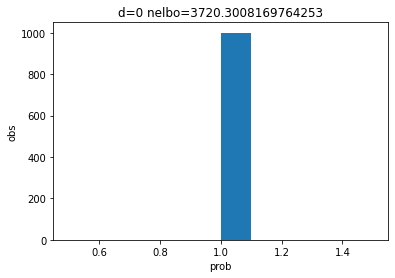

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,27911
nelbo,3720.30082
entropy,-693.146
reconstruction_loss,-4413.44681
_runtime,447
_timestamp,1630686006
_step,27910


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,▇▄▂▂▁▁▁▁▁▁█▂▂▂▂▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
entropy,▁▂▃▂▂▂▂▂▂▂▃▁▂▂▂▂▁▁▁▁▁▁▁▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
reconstruction_loss,▂▅▇▇██████▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 38974.31592856406; pi: tensor([0.2371, 0.4784, 0.2844], dtype=torch.float64)
NELBO: 2969.943720887499; pi: tensor([0.2420, 0.4646, 0.2934], dtype=torch.float64)
NELBO: 1751.5990893909252; pi: tensor([0.2429, 0.4632, 0.2939], dtype=torch.float64)
NELBO: 1276.3387869568578; pi: tensor([0.2438, 0.4619, 0.2944], dtype=torch.float64)
NELBO: 930.4867769290167; pi: tensor([0.2446, 0.4605, 0.2949], dtype=torch.float64)
NELBO: 695.7153377433328; pi: tensor([0.2455, 0.4592, 0.2953], dtype=torch.float64)
NELBO: 575.6872523437555; pi: tensor([0.2463, 0.4579, 0.2958], dtype=torch.float64)
NELBO: 505.61687466206354; pi: tensor([0.2471, 0.4566, 0.2963], dtype=torch.float64)
NELBO: 3788.5853934485312; pi: tensor([0.2479, 0.4554, 0.2967], dtype=torch.float64)
NELBO: 3355.6475012757674; pi: tensor([0.2488, 0.4541, 0.2971], dtype=torch.float64)
NELBO: 3333.6967428465987; pi: tensor([0.2496, 0.4529, 0.2976], dtype=torch.float64)
NELBO: 3325.310008663745; pi: tensor([0.2504, 0.4516, 0.2980], dtype=t

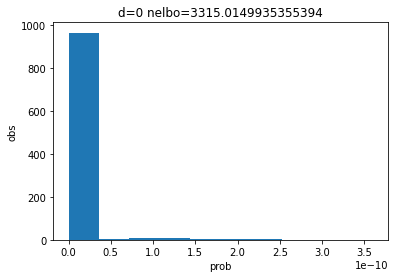

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,17215
nelbo,3315.01499
entropy,-1100.22852
reconstruction_loss,-4415.24351
_runtime,269
_timestamp,1630686281
_step,17214


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▆▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
entropy,▂▁▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆██████████████████████
reconstruction_loss,▁▃▇▇▇▇▇▇██████████▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 37999.80040909878; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 3376.992709460812; pi: tensor([0.4715, 0.2838, 0.2447], dtype=torch.float64)
NELBO: 2307.6371354015964; pi: tensor([0.4701, 0.2844, 0.2456], dtype=torch.float64)
NELBO: 2041.542338027593; pi: tensor([0.4687, 0.2849, 0.2464], dtype=torch.float64)
NELBO: 1188.651585080539; pi: tensor([0.4673, 0.2855, 0.2472], dtype=torch.float64)
NELBO: 807.0013743487311; pi: tensor([0.4659, 0.2860, 0.2481], dtype=torch.float64)
NELBO: 636.3103893590633; pi: tensor([0.4645, 0.2866, 0.2489], dtype=torch.float64)
NELBO: 528.7042382306195; pi: tensor([0.4632, 0.2871, 0.2497], dtype=torch.float64)
NELBO: 486.6109065509563; pi: tensor([0.4618, 0.2877, 0.2505], dtype=torch.float64)
NELBO: 480.188247706069; pi: tensor([0.4605, 0.2882, 0.2513], dtype=torch.float64)
trial: 2 NELBO: 478.19620947874


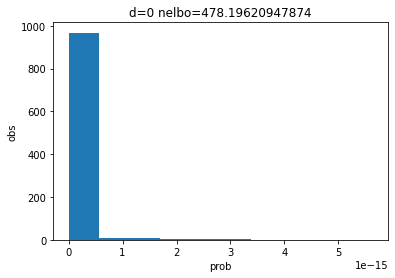

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,9787
nelbo,478.19621
entropy,-1630.62073
reconstruction_loss,-2108.81694
_runtime,151
_timestamp,1630686436
_step,9786


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂▁▅█████████████████████████████████████
reconstruction_loss,▁▂▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 38367.84202583757; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 446.17276271605897; pi: tensor([0.7311, 0.1890, 0.0799], dtype=torch.float64)
NELBO: -2.3548304865744285; pi: tensor([0.7697, 0.1947, 0.0356], dtype=torch.float64)
NELBO: -296.8855354991199; pi: tensor([0.7830, 0.1984, 0.0186], dtype=torch.float64)
NELBO: -444.2800533124671; pi: tensor([0.7893, 0.2001, 0.0106], dtype=torch.float64)
NELBO: -502.19803517510127; pi: tensor([0.7927, 0.2010, 0.0063], dtype=torch.float64)
NELBO: -523.6976104488588; pi: tensor([0.7947, 0.2015, 0.0039], dtype=torch.float64)
NELBO: -536.8257236100194; pi: tensor([0.7958, 0.2018, 0.0024], dtype=torch.float64)
NELBO: -543.0233615547033; pi: tensor([0.7965, 0.2020, 0.0015], dtype=torch.float64)
NELBO: 2383.0961373867085; pi: tensor([9.2045e-01, 7.8883e-02, 6.6386e-04], dtype=torch.float64)
NELBO: 1867.6351559982409; pi: tensor([9.8105e-01, 1.8648e-02, 3.0015e-04], dtype=torch.float64)
NELBO: 3975.118073105076; pi: tensor([9.

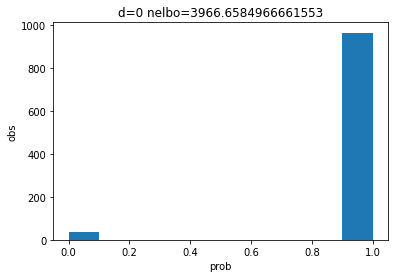

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,16482
nelbo,3966.6585
entropy,-0.00013
reconstruction_loss,-3966.65862
_runtime,271
_timestamp,1630686712
_step,16481


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
entropy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂███████████████
reconstruction_loss,▁▇▇▇▇█████████████████▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43579.825829437745; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 2355.1092134256764; pi: tensor([0.4598, 0.3073, 0.2328], dtype=torch.float64)
NELBO: 1561.8711427532426; pi: tensor([0.4585, 0.3077, 0.2338], dtype=torch.float64)
NELBO: 1208.5668091008938; pi: tensor([0.4573, 0.3080, 0.2347], dtype=torch.float64)
NELBO: 914.5621501294631; pi: tensor([0.4560, 0.3084, 0.2356], dtype=torch.float64)
NELBO: 687.4822302485532; pi: tensor([0.4547, 0.3088, 0.2365], dtype=torch.float64)
NELBO: 3809.633479517769; pi: tensor([0.4535, 0.3091, 0.2374], dtype=torch.float64)
NELBO: 3359.240856238621; pi: tensor([0.4523, 0.3094, 0.2383], dtype=torch.float64)
NELBO: 3332.8668639224916; pi: tensor([0.4511, 0.3098, 0.2392], dtype=torch.float64)
NELBO: 3325.3582047720847; pi: tensor([0.4499, 0.3101, 0.2400], dtype=torch.float64)
NELBO: 3321.137998297909; pi: tensor([0.4487, 0.3104, 0.2409], dtype=torch.float64)
NELBO: 3318.6581108822174; pi: tensor([0.4475, 0.3108, 0.2418], dtype=

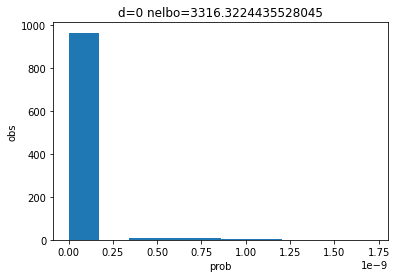

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12863
nelbo,3316.32244
entropy,-1325.17505
reconstruction_loss,-4641.49749
_runtime,206
_timestamp,1630686922
_step,12862


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
entropy,▅▁▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
reconstruction_loss,▁▅▇▇▇▇███████████▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 44276.83012381444; pi: tensor([0.2840, 0.4787, 0.2372], dtype=torch.float64)
NELBO: 395.51948091124177; pi: tensor([0.1852, 0.7298, 0.0850], dtype=torch.float64)
NELBO: -20.52274139328256; pi: tensor([0.1911, 0.7699, 0.0390], dtype=torch.float64)
NELBO: -293.79414649081355; pi: tensor([0.1965, 0.7828, 0.0207], dtype=torch.float64)
NELBO: -432.6715178911045; pi: tensor([0.1990, 0.7891, 0.0118], dtype=torch.float64)
NELBO: -500.9188792320076; pi: tensor([0.2003, 0.7926, 0.0071], dtype=torch.float64)
NELBO: -541.0283902022054; pi: tensor([0.2011, 0.7946, 0.0043], dtype=torch.float64)
NELBO: -562.5605570721366; pi: tensor([0.2016, 0.7958, 0.0027], dtype=torch.float64)
NELBO: -578.2315561362325; pi: tensor([0.2018, 0.7965, 0.0017], dtype=torch.float64)
NELBO: -583.2832906016122; pi: tensor([0.2020, 0.7969, 0.0011], dtype=torch.float64)
NELBO: -584.2848352590474; pi: tensor([2.0210e-01, 7.9723e-01, 6.7204e-04], dtype=torch.float64)
NELBO: -584.6601414552838; pi: tensor([2.0217e-01, 7.

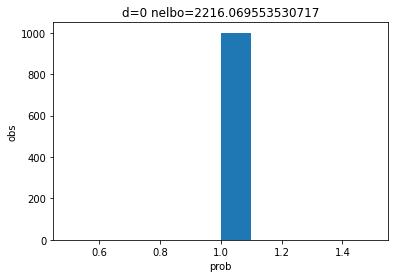

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,27664
nelbo,2216.06955
entropy,-2197.22461
reconstruction_loss,-4413.29416
_runtime,486
_timestamp,1630687413
_step,27663


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂▄▄▄▄▄▃▃▃▃▃▃▃
entropy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█████▂▂▂▂▂▂▂
reconstruction_loss,▁▇████████████████▆▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41627.88473436264; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 3067.105288616055; pi: tensor([0.4569, 0.3000, 0.2431], dtype=torch.float64)
NELBO: 1759.6625229090841; pi: tensor([0.4556, 0.3005, 0.2439], dtype=torch.float64)
NELBO: 1222.531091128319; pi: tensor([0.4544, 0.3009, 0.2448], dtype=torch.float64)
NELBO: 873.4275433899929; pi: tensor([0.4531, 0.3013, 0.2456], dtype=torch.float64)
NELBO: 697.9230775584692; pi: tensor([0.4519, 0.3017, 0.2464], dtype=torch.float64)
NELBO: 638.6250505299547; pi: tensor([0.4507, 0.3021, 0.2472], dtype=torch.float64)
NELBO: 618.6054546178773; pi: tensor([0.4495, 0.3025, 0.2481], dtype=torch.float64)
NELBO: 609.7335232652351; pi: tensor([0.4483, 0.3029, 0.2489], dtype=torch.float64)
NELBO: 604.6226209718704; pi: tensor([0.4471, 0.3032, 0.2497], dtype=torch.float64)
NELBO: 601.1780284072834; pi: tensor([0.4459, 0.3036, 0.2505], dtype=torch.float64)
NELBO: 598.7845017428037; pi: tensor([0.4448, 0.3040, 0.2512], dtype=torch.

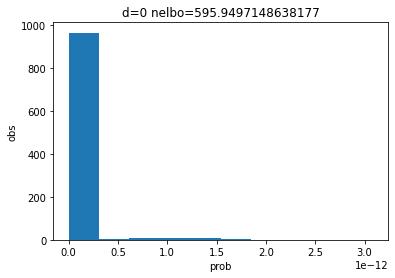

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13128
nelbo,595.94971
entropy,-1123.51282
reconstruction_loss,-1719.46253
_runtime,214
_timestamp,1630687632
_step,13127


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁███████████████████████████████████████
reconstruction_loss,▁▆▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41588.57838409336; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 554.7017159436291; pi: tensor([0.6861, 0.2059, 0.1080], dtype=torch.float64)
NELBO: -10.48797895988173; pi: tensor([0.7536, 0.1895, 0.0569], dtype=torch.float64)
NELBO: -321.5643346358154; pi: tensor([0.7647, 0.1936, 0.0417], dtype=torch.float64)
NELBO: -496.87004807539665; pi: tensor([0.7680, 0.1948, 0.0372], dtype=torch.float64)
NELBO: -561.9466896963595; pi: tensor([0.7687, 0.1950, 0.0363], dtype=torch.float64)
NELBO: -589.2450772907773; pi: tensor([0.7688, 0.1950, 0.0362], dtype=torch.float64)
NELBO: -606.0918233849816; pi: tensor([0.7689, 0.1950, 0.0361], dtype=torch.float64)
NELBO: -617.7964043303746; pi: tensor([0.7689, 0.1950, 0.0361], dtype=torch.float64)
NELBO: -621.9975483780274; pi: tensor([0.7690, 0.1950, 0.0360], dtype=torch.float64)
NELBO: -623.1666111593493; pi: tensor([0.7690, 0.1950, 0.0360], dtype=torch.float64)
trial: 7 NELBO: -623.249821165105


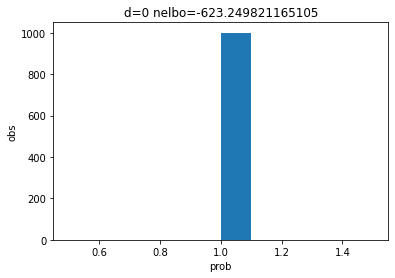

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10100
nelbo,-623.24982
entropy,-2197.22363
reconstruction_loss,-1573.97381
_runtime,155
_timestamp,1630687792
_step,10099


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▃▇▇████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43121.31391459696; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 502.76942286503163; pi: tensor([0.7353, 0.1908, 0.0740], dtype=torch.float64)
NELBO: 58.34495544295714; pi: tensor([0.7715, 0.1962, 0.0323], dtype=torch.float64)
NELBO: -224.58491799329295; pi: tensor([0.7841, 0.1992, 0.0168], dtype=torch.float64)
NELBO: -381.10198935761764; pi: tensor([0.7900, 0.2005, 0.0095], dtype=torch.float64)
NELBO: -462.834795670434; pi: tensor([0.7931, 0.2012, 0.0057], dtype=torch.float64)
NELBO: -509.25432550143796; pi: tensor([0.7949, 0.2016, 0.0035], dtype=torch.float64)
NELBO: -528.347340261821; pi: tensor([0.7960, 0.2019, 0.0021], dtype=torch.float64)
NELBO: -539.3530487738378; pi: tensor([0.7966, 0.2020, 0.0013], dtype=torch.float64)
NELBO: -543.8343771041839; pi: tensor([0.7970, 0.2021, 0.0008], dtype=torch.float64)
NELBO: -544.8053966764119; pi: tensor([7.9728e-01, 2.0219e-01, 5.3198e-04], dtype=torch.float64)
trial: 8 NELBO: -545.0311118076286


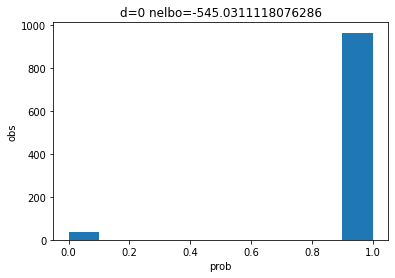

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10715
nelbo,-545.03111
entropy,-2118.08716
reconstruction_loss,-1573.05605
_runtime,165
_timestamp,1630687962
_step,10714


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▆██████████████████████████████████████
reconstruction_loss,▁▆▇█████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 42199.076322404035; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 448.2083575543488; pi: tensor([0.7384, 0.1879, 0.0738], dtype=torch.float64)
NELBO: 0.8743631332777113; pi: tensor([0.7727, 0.1949, 0.0324], dtype=torch.float64)
NELBO: -310.3950717867219; pi: tensor([0.7847, 0.1985, 0.0169], dtype=torch.float64)
NELBO: -466.46317821649063; pi: tensor([0.7903, 0.2001, 0.0096], dtype=torch.float64)
NELBO: -527.8485216861673; pi: tensor([0.7933, 0.2010, 0.0057], dtype=torch.float64)
NELBO: -553.6462067036505; pi: tensor([0.7950, 0.2015, 0.0035], dtype=torch.float64)
NELBO: -567.7936693931015; pi: tensor([0.7960, 0.2018, 0.0022], dtype=torch.float64)
NELBO: -579.076623240959; pi: tensor([0.7967, 0.2020, 0.0014], dtype=torch.float64)
NELBO: -583.4606959636478; pi: tensor([0.7971, 0.2021, 0.0009], dtype=torch.float64)
trial: 9 NELBO: -583.9211397356628


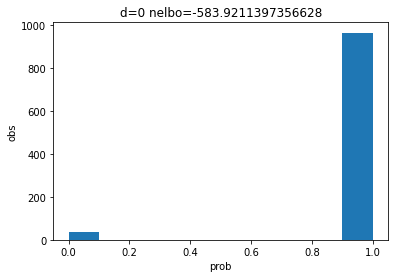

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,9315
nelbo,-583.92114
entropy,-2157.66602
reconstruction_loss,-1573.74488
_runtime,144
_timestamp,1630688110
_step,9314


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▁█▇▇▇▇▇▇▇▇▇▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
reconstruction_loss,▁▆▇█████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 40843.81412191054; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 344.069586984589; pi: tensor([0.7212, 0.1892, 0.0896], dtype=torch.float64)
NELBO: -53.013950739193206; pi: tensor([0.7563, 0.1909, 0.0528], dtype=torch.float64)
NELBO: -331.020765231935; pi: tensor([0.7655, 0.1940, 0.0405], dtype=torch.float64)
NELBO: -496.6659143816689; pi: tensor([0.7682, 0.1949, 0.0369], dtype=torch.float64)
NELBO: -571.4928158523178; pi: tensor([0.7687, 0.1950, 0.0363], dtype=torch.float64)
NELBO: -601.0779110831961; pi: tensor([0.7689, 0.1950, 0.0361], dtype=torch.float64)
NELBO: -615.1146855854977; pi: tensor([0.7689, 0.1950, 0.0361], dtype=torch.float64)
NELBO: -622.2076376463058; pi: tensor([0.7689, 0.1950, 0.0361], dtype=torch.float64)
NELBO: -623.7589518509753; pi: tensor([0.7690, 0.1950, 0.0360], dtype=torch.float64)
NELBO: -624.1667165440304; pi: tensor([0.7690, 0.1950, 0.0360], dtype=torch.float64)
trial: 10 NELBO: -624.1795302807484


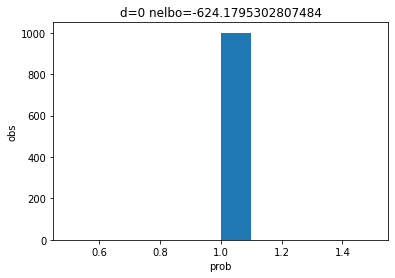

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10034
nelbo,-624.17953
entropy,-2197.22437
reconstruction_loss,-1573.04483
_runtime,158
_timestamp,1630688273
_step,10033


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▃▇█████████████████████████████████████
reconstruction_loss,▁▅▇▇████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43667.447234133026; pi: tensor([0.2844, 0.4784, 0.2371], dtype=torch.float64)
NELBO: 2832.723217008175; pi: tensor([0.2937, 0.4680, 0.2383], dtype=torch.float64)
NELBO: 1888.9231306795923; pi: tensor([0.2941, 0.4667, 0.2392], dtype=torch.float64)
NELBO: 1459.030737992297; pi: tensor([0.2946, 0.4653, 0.2401], dtype=torch.float64)
NELBO: 1099.6912869000853; pi: tensor([0.2951, 0.4639, 0.2410], dtype=torch.float64)
NELBO: 836.861956680485; pi: tensor([0.2956, 0.4626, 0.2418], dtype=torch.float64)
NELBO: 694.7420912260577; pi: tensor([0.2960, 0.4613, 0.2427], dtype=torch.float64)
NELBO: 625.5885258789285; pi: tensor([0.2965, 0.4599, 0.2436], dtype=torch.float64)
NELBO: 609.5310426967467; pi: tensor([0.2970, 0.4586, 0.2444], dtype=torch.float64)
NELBO: 604.2310470891089; pi: tensor([0.2974, 0.4574, 0.2452], dtype=torch.float64)
NELBO: 3779.2071963273183; pi: tensor([0.2978, 0.4561, 0.2461], dtype=torch.float64)
NELBO: 3366.525747451812; pi: tensor([0.2983, 0.4548, 0.2469], dtype=torc

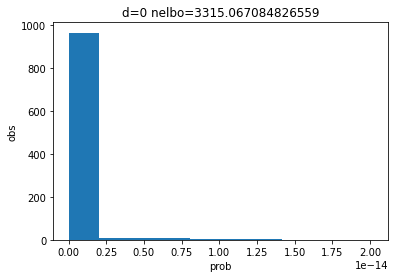

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,19999
nelbo,3315.06708
entropy,-1098.69666
reconstruction_loss,-4413.76374
_runtime,322
_timestamp,1630688599
_step,19998


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
entropy,▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄█████████████████████
reconstruction_loss,▁▅▇▇▇▇▇████████████▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 42281.91287260145; pi: tensor([0.2844, 0.4784, 0.2371], dtype=torch.float64)
NELBO: 2949.6513405174373; pi: tensor([0.1010, 0.8156, 0.0834], dtype=torch.float64)
NELBO: 1544.2948537980446; pi: tensor([0.0429, 0.9211, 0.0360], dtype=torch.float64)
NELBO: 1117.7340533089005; pi: tensor([0.0217, 0.9599, 0.0184], dtype=torch.float64)
NELBO: 859.242120517878; pi: tensor([0.0121, 0.9776, 0.0103], dtype=torch.float64)
NELBO: 730.9089398324222; pi: tensor([0.0071, 0.9868, 0.0061], dtype=torch.float64)
NELBO: 661.5682787709763; pi: tensor([0.0043, 0.9920, 0.0037], dtype=torch.float64)
NELBO: 639.0552015667881; pi: tensor([0.0027, 0.9950, 0.0023], dtype=torch.float64)
NELBO: 633.7312458630208; pi: tensor([0.0017, 0.9969, 0.0014], dtype=torch.float64)
NELBO: 632.1555964477081; pi: tensor([1.0445e-03, 9.9806e-01, 8.9455e-04], dtype=torch.float64)
NELBO: 628.4689998527979; pi: tensor([6.5791e-04, 9.9878e-01, 5.6389e-04], dtype=torch.float64)
NELBO: 626.7006902387029; pi: tensor([4.1544e-04, 

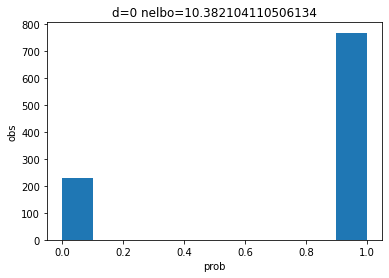

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,17349
nelbo,10.3821
entropy,-1708.52588
reconstruction_loss,-1718.90798
_runtime,263
_timestamp,1630688868
_step,17348


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁██▇██████████████████████▅▄▄▄▄▄▅▅▅▅▅▅▅▅
reconstruction_loss,▁▆▇▇▇███████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 40971.38821429841; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 1293.2633119518591; pi: tensor([0.7050, 0.2148, 0.0802], dtype=torch.float64)
NELBO: 706.2453994999169; pi: tensor([0.7417, 0.2227, 0.0356], dtype=torch.float64)
NELBO: 558.7427852688133; pi: tensor([0.7547, 0.2267, 0.0186], dtype=torch.float64)
NELBO: 515.3186806337358; pi: tensor([0.7609, 0.2286, 0.0106], dtype=torch.float64)
NELBO: 501.1943274423961; pi: tensor([0.7642, 0.2296, 0.0063], dtype=torch.float64)
NELBO: 495.5142580119168; pi: tensor([0.7660, 0.2301, 0.0038], dtype=torch.float64)
NELBO: 492.39192949180915; pi: tensor([0.7672, 0.2304, 0.0024], dtype=torch.float64)
NELBO: 490.3518700702143; pi: tensor([0.7679, 0.2306, 0.0015], dtype=torch.float64)
NELBO: 2935.57864276674; pi: tensor([0.2421, 0.7541, 0.0038], dtype=torch.float64)
NELBO: 2065.0363570777254; pi: tensor([0.0954, 0.8944, 0.0102], dtype=torch.float64)
NELBO: 1858.9301349050488; pi: tensor([0.0498, 0.9307, 0.0195], dtype=torc

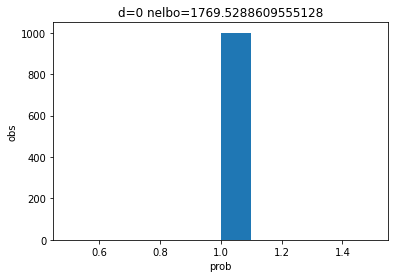

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,19729
nelbo,1769.52886
entropy,-2197.22632
reconstruction_loss,-3966.75518
_runtime,334
_timestamp,1630689206
_step,19728


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
entropy,▁████████████████▇██████████████████████
reconstruction_loss,▂▅▇▇█████████████▁▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 40769.209932026206; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 3535.8599842948697; pi: tensor([0.4326, 0.2990, 0.2685], dtype=torch.float64)
NELBO: 2125.420681819718; pi: tensor([0.4315, 0.2993, 0.2691], dtype=torch.float64)
NELBO: 1788.0660339574251; pi: tensor([0.4305, 0.2997, 0.2698], dtype=torch.float64)
NELBO: 1681.665137272605; pi: tensor([0.4295, 0.3001, 0.2704], dtype=torch.float64)
NELBO: 1637.3103241955387; pi: tensor([0.4285, 0.3005, 0.2710], dtype=torch.float64)
NELBO: 1616.0408038261535; pi: tensor([0.4275, 0.3009, 0.2716], dtype=torch.float64)
NELBO: 1604.3207434422288; pi: tensor([0.4265, 0.3012, 0.2722], dtype=torch.float64)
NELBO: 1597.3691002173823; pi: tensor([0.4256, 0.3016, 0.2728], dtype=torch.float64)
NELBO: 1593.1304815573385; pi: tensor([0.4246, 0.3019, 0.2734], dtype=torch.float64)
NELBO: 1590.507526194402; pi: tensor([0.4237, 0.3023, 0.2740], dtype=torch.float64)
NELBO: 1859.995705462004; pi: tensor([0.4201, 0.3026, 0.2773], dtype

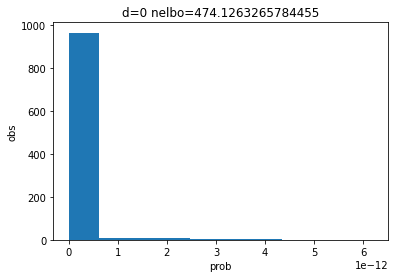

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,19948
nelbo,474.12633
entropy,-1098.6123
reconstruction_loss,-1572.73863
_runtime,318
_timestamp,1630689528
_step,19947


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
entropy,▁███████████████████████████████████████
reconstruction_loss,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 39866.17658423063; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 3304.7255210849844; pi: tensor([0.4647, 0.3075, 0.2278], dtype=torch.float64)
NELBO: 1670.1819836026243; pi: tensor([0.4633, 0.3079, 0.2287], dtype=torch.float64)
NELBO: 1243.563825311047; pi: tensor([0.4620, 0.3083, 0.2297], dtype=torch.float64)
NELBO: 920.6716317046662; pi: tensor([0.4607, 0.3087, 0.2306], dtype=torch.float64)
NELBO: 697.7263605440903; pi: tensor([0.4594, 0.3090, 0.2316], dtype=torch.float64)
NELBO: 579.9018783646106; pi: tensor([0.4581, 0.3094, 0.2325], dtype=torch.float64)
NELBO: 510.5183126425395; pi: tensor([0.4568, 0.3097, 0.2334], dtype=torch.float64)
NELBO: 487.8730350450089; pi: tensor([0.4556, 0.3101, 0.2343], dtype=torch.float64)
NELBO: 480.13404776734774; pi: tensor([0.4543, 0.3104, 0.2353], dtype=torch.float64)
NELBO: 477.58076494049556; pi: tensor([0.4531, 0.3108, 0.2362], dtype=torch.float64)
NELBO: 476.2270712887687; pi: tensor([0.4519, 0.3111, 0.2371], dtype=tor

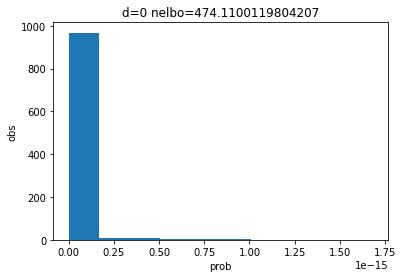

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,15992
nelbo,474.11001
entropy,-1271.72827
reconstruction_loss,-1745.83828
_runtime,259
_timestamp,1630689793
_step,15991


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▆▁▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████
reconstruction_loss,▁▅▆▇▇▇▇▇████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 39769.69383225593; pi: tensor([0.4784, 0.2371, 0.2844], dtype=torch.float64)
NELBO: 3378.949531063614; pi: tensor([0.4642, 0.2404, 0.2954], dtype=torch.float64)
NELBO: 2054.7342483103453; pi: tensor([0.4628, 0.2413, 0.2959], dtype=torch.float64)
NELBO: 1574.3588253510243; pi: tensor([0.4615, 0.2422, 0.2964], dtype=torch.float64)
NELBO: 1149.3096012316528; pi: tensor([0.4602, 0.2430, 0.2968], dtype=torch.float64)
NELBO: 859.1946811896028; pi: tensor([0.4589, 0.2439, 0.2973], dtype=torch.float64)
NELBO: 717.0259773204439; pi: tensor([0.4576, 0.2447, 0.2977], dtype=torch.float64)
NELBO: 633.7802121625709; pi: tensor([0.4563, 0.2456, 0.2981], dtype=torch.float64)
NELBO: 608.9347187143062; pi: tensor([0.4550, 0.2464, 0.2986], dtype=torch.float64)
NELBO: 603.6341441821878; pi: tensor([0.4538, 0.2472, 0.2990], dtype=torch.float64)
NELBO: 600.5160970114052; pi: tensor([0.4525, 0.2480, 0.2994], dtype=torch.float64)
NELBO: 598.3882423268865; pi: tensor([0.4513, 0.2488, 0.2998], dtype=torc

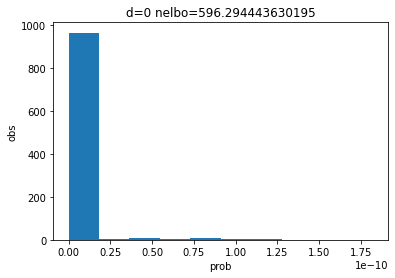

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12599
nelbo,596.29444
entropy,-1385.04138
reconstruction_loss,-1981.33583
_runtime,206
_timestamp,1630690004
_step,12598


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
reconstruction_loss,▁▅▆▇▇▇▇▇▇▇▇█████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 42393.24245597287; pi: tensor([0.2371, 0.4784, 0.2844], dtype=torch.float64)
NELBO: 496.2886177374876; pi: tensor([0.0721, 0.7389, 0.1890], dtype=torch.float64)
NELBO: 40.388945437226994; pi: tensor([0.0315, 0.7729, 0.1956], dtype=torch.float64)
NELBO: -249.84236934177534; pi: tensor([0.0164, 0.7848, 0.1989], dtype=torch.float64)
NELBO: -405.3086269848541; pi: tensor([0.0093, 0.7903, 0.2004], dtype=torch.float64)
NELBO: -479.54955449080853; pi: tensor([0.0055, 0.7933, 0.2011], dtype=torch.float64)
NELBO: 2314.6158634383673; pi: tensor([0.0025, 0.9150, 0.0825], dtype=torch.float64)
NELBO: 4009.766395916817; pi: tensor([0.0012, 0.9769, 0.0220], dtype=torch.float64)
NELBO: 3985.151642067961; pi: tensor([7.1996e-04, 9.8863e-01, 1.0646e-02], dtype=torch.float64)
NELBO: 3973.766359817392; pi: tensor([4.7500e-04, 9.9359e-01, 5.9383e-03], dtype=torch.float64)
NELBO: 3970.1453861653977; pi: tensor([3.1817e-04, 9.9617e-01, 3.5138e-03], dtype=torch.float64)
NELBO: 3968.561708807789; pi: te

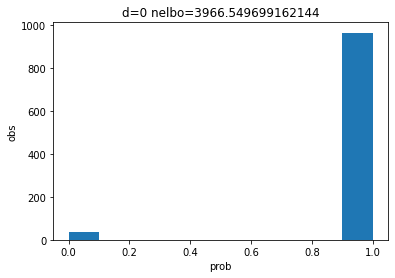

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14594
nelbo,3966.5497
entropy,-0.00034
reconstruction_loss,-3966.55004
_runtime,275
_timestamp,1630690284
_step,14593


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
entropy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████
reconstruction_loss,▁▇██████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43721.88528851383; pi: tensor([0.2844, 0.4784, 0.2371], dtype=torch.float64)
NELBO: 2953.569300437207; pi: tensor([0.2948, 0.4652, 0.2400], dtype=torch.float64)
NELBO: 1693.1944789610384; pi: tensor([0.2953, 0.4638, 0.2408], dtype=torch.float64)
NELBO: 1269.5547256964815; pi: tensor([0.2958, 0.4625, 0.2417], dtype=torch.float64)
NELBO: 947.8756498551279; pi: tensor([0.2963, 0.4612, 0.2426], dtype=torch.float64)
NELBO: 710.9815179401289; pi: tensor([0.2967, 0.4599, 0.2434], dtype=torch.float64)
NELBO: 578.5768251062809; pi: tensor([0.2972, 0.4586, 0.2443], dtype=torch.float64)
NELBO: 510.1307709730215; pi: tensor([0.2976, 0.4573, 0.2451], dtype=torch.float64)
NELBO: 487.53023431770725; pi: tensor([0.2980, 0.4560, 0.2460], dtype=torch.float64)
NELBO: 480.23483871224585; pi: tensor([0.2985, 0.4547, 0.2468], dtype=torch.float64)
NELBO: 477.60142616029793; pi: tensor([0.2989, 0.4535, 0.2476], dtype=torch.float64)
NELBO: 476.1872555103039; pi: tensor([0.2993, 0.4522, 0.2484], dtype=to

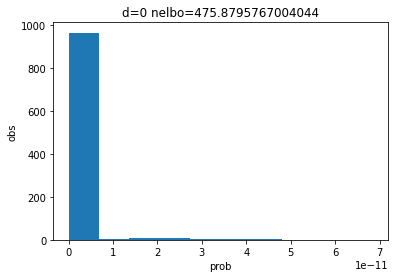

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11303
nelbo,475.87958
entropy,-1341.21143
reconstruction_loss,-1817.091
_runtime,178
_timestamp,1630690466
_step,11302


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▅▁▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
reconstruction_loss,▁▃▆▇▇▇▇▇▇▇██████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41101.47206619619; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 2634.8474327685535; pi: tensor([0.8286, 0.0925, 0.0789], dtype=torch.float64)
NELBO: 1561.7872845030843; pi: tensor([0.9273, 0.0390, 0.0337], dtype=torch.float64)
NELBO: 1156.30138051709; pi: tensor([0.9630, 0.0198, 0.0172], dtype=torch.float64)
NELBO: 858.2223937194003; pi: tensor([0.9793, 0.0111, 0.0096], dtype=torch.float64)
NELBO: 697.2012227008072; pi: tensor([0.9878, 0.0065, 0.0057], dtype=torch.float64)
NELBO: 628.1537427075284; pi: tensor([0.9926, 0.0040, 0.0035], dtype=torch.float64)
NELBO: 609.4566126687394; pi: tensor([0.9954, 0.0024, 0.0021], dtype=torch.float64)
NELBO: 604.2327118870589; pi: tensor([0.9971, 0.0015, 0.0013], dtype=torch.float64)
NELBO: 601.4992914263375; pi: tensor([9.9821e-01, 9.5654e-04, 8.3736e-04], dtype=torch.float64)
trial: 19 NELBO: 600.4415678002765


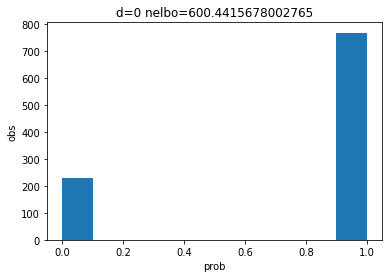

In [9]:
for trial in range(nt):
  
  Y = np.array(Y)
  S = np.array(S)
  kms = [KMeans(nc).fit(Y) for i in range(N_INIT)]
  inertias = [k.inertia_ for k in kms]
  km = kms[np.argmin(np.array(inertias))] ## selected "best" kmeans based on inertia score
  init_labels = km.labels_
  
  mu_init = np.array([Y[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
  sigma_init = np.array([Y[init_labels == i,:].std(0) for i in np.unique(init_labels)])
  psi_init = np.array([S[init_labels == i].mean() for i in np.unique(init_labels)])
  omega_init = np.array([S[init_labels == i].std() for i in np.unique(init_labels)])
  pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
  tau_init = np.ones((nc,nc))
  tau_init = tau_init / tau_init.sum()

  Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": F.log_softmax(torch.tensor([0.95, 1-0.95])),
    'is_pi': F.log_softmax(torch.tensor(pi_init)),
    'is_tau': F.log_softmax(torch.tensor(tau_init))
  }
  Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

  #Theta['is_delta'].requires_grad = False
  #Theta['is_pi'].requires_grad = False
  #Theta['is_tau'].requires_grad = False

  r_net = BasicForwardNet(P, nc)
  v_net = BasicForwardNet(P, nc ** 2)
  d_net = BasicForwardNet(P, 2)

  Y = torch.tensor(Y)
  S = torch.tensor(S)
  YS = torch.hstack((Y,S.reshape(-1,1))).float()

  params = list(Theta.values()) + list(r_net.parameters()) + list(v_net.parameters()) + list(d_net.parameters())
  opt = optim.AdamW(params, lr=lr)

  wandb.init(project='jett-vi_lr1e-3_hd20_hl5',
           config={
    "N_EPOCHS": N_ITER,
    "LR": lr,
    "TOL": tol,
    'MODEL_TYPE': 'vi',
    'DATA_TYPE': 'toy_data'
  })

  loss = []
  for i in range(N_ITER):
  
    opt.zero_grad()
    r, log_r = r_net(YS)
    v, log_v = v_net(YS)
    d, log_d = d_net(YS)
  
    ## row sums to 1 (from neural net)
    log_q0 = log_d[:,0].reshape(-1,1) + log_r ## like r in em version
    log_q1 = log_d[:,1].reshape(-1,1) + log_v ## like v in em version
    
    log_rzd0, log_vgd1 = compute_joint_probs(Theta, Y, S)

    entro = (d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
    recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()

    #entro = (log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()
    #recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()
    nelbo = entro - recon

    #nelbo = (log_q0.exp() * (log_q0 - log_rzd0)).sum() + (log_q1.exp() * (log_q1 - log_vgd1)).sum()

    nelbo.backward()
    opt.step()
  
    wandb.log({
      'ITER': i + 1, 
      'nelbo': nelbo.detach(),
      'entropy': entro.detach(),
      'reconstruction_loss': recon.detach(),
      'log_mu': Theta['log_mu'],
      'log_sigma': Theta['log_sigma'], #np.zeros_like(sigma_init),
      'log_psi': Theta['log_psi'],
      'log_omega': Theta['log_omega'],
      "is_delta": Theta['is_delta'],
      'is_pi': Theta['is_pi'],
      'is_tau': Theta['is_tau'],
      'r': r,
      'v': v,
      'd': d,
      })
  
    if i % (1000 - 1) == 0:
      #print("NELBO: {}; lambda: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      #print("NELBO: {}; entro: {}; recon: {}; pi: {}".format(nelbo.detach(), entro.detach(), recon.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      print("NELBO: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  
    if i > 0 and abs(loss[-1] - nelbo.detach()) < tol:
      break
           
    loss.append(nelbo.detach())

  print("trial: {} NELBO: {}".format(trial, nelbo.detach()))

  plt.figure()
  plt.hist(np.array(d.T[0].detach().numpy()))
  plt.title('d=0 nelbo={}'.format(nelbo.detach()))
  plt.xlabel('prob')
  plt.ylabel('obs')
  plt.show()

In [10]:
np.exp(theta_true['log_lambda0'])

0.94

In [11]:
np.exp(theta_true['log_pi'])

array([0.03784219, 0.22368854, 0.73846927])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,9389
nelbo,600.44157
entropy,-1123.27454
reconstruction_loss,-1723.7161
_runtime,148
_timestamp,1630690618
_step,9388


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁█▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▆▆▇▇▇▇▇████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 38469.6714260672; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 3877.2697579897103; pi: tensor([0.2774, 0.6098, 0.1128], dtype=torch.float64)
NELBO: 1993.7683409650158; pi: tensor([0.2929, 0.5760, 0.1310], dtype=torch.float64)
NELBO: 1510.182325135363; pi: tensor([0.2981, 0.5649, 0.1370], dtype=torch.float64)
NELBO: 1141.1631646386932; pi: tensor([0.3002, 0.5600, 0.1398], dtype=torch.float64)
NELBO: 871.9167378255215; pi: tensor([0.3012, 0.5573, 0.1415], dtype=torch.float64)
NELBO: 720.1586382627052; pi: tensor([0.3019, 0.5551, 0.1429], dtype=torch.float64)
NELBO: 636.2938939524483; pi: tensor([0.3026, 0.5530, 0.1444], dtype=torch.float64)
NELBO: 612.5591633464082; pi: tensor([0.3033, 0.5509, 0.1458], dtype=torch.float64)
NELBO: 605.0592960121021; pi: tensor([0.3040, 0.5488, 0.1472], dtype=torch.float64)
NELBO: 601.4121016968552; pi: tensor([0.3047, 0.5468, 0.1486], dtype=torch.float64)
NELBO: 599.97257422336; pi: tensor([0.3053, 0.5448, 0.1499], dtype=torch.f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


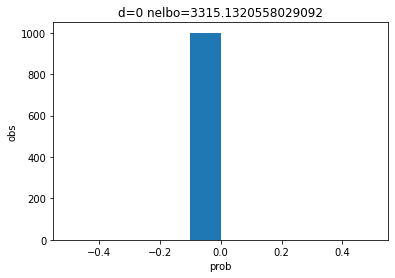

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,21598
nelbo,3315.13206
entropy,-1098.61218
reconstruction_loss,-4413.74424
_runtime,313
_timestamp,1630693283
_step,21597


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
entropy,▁▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆███████████████████
reconstruction_loss,▁▆▇▇▇▇███████████████▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41267.256091109855; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 3948.157309256575; pi: tensor([0.4087, 0.5056, 0.0857], dtype=torch.float64)
NELBO: 2003.2811003876936; pi: tensor([0.3819, 0.5111, 0.1070], dtype=torch.float64)
NELBO: 1512.9331558392923; pi: tensor([0.3828, 0.5033, 0.1139], dtype=torch.float64)
NELBO: 1144.3355192653748; pi: tensor([0.3831, 0.5000, 0.1169], dtype=torch.float64)
NELBO: 879.0019857863176; pi: tensor([0.3831, 0.4983, 0.1186], dtype=torch.float64)
NELBO: 733.7615580455299; pi: tensor([0.3831, 0.4969, 0.1200], dtype=torch.float64)
NELBO: 642.495035140535; pi: tensor([0.3831, 0.4955, 0.1214], dtype=torch.float64)
NELBO: 613.3740702449613; pi: tensor([0.3830, 0.4942, 0.1228], dtype=torch.float64)
NELBO: 605.391701145405; pi: tensor([0.3830, 0.4928, 0.1242], dtype=torch.float64)
NELBO: 601.6717402670624; pi: tensor([0.3829, 0.4915, 0.1256], dtype=torch.float64)
NELBO: 3425.6952671589916; pi: tensor([0.3828, 0.4902, 0.1269], dtype=torc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


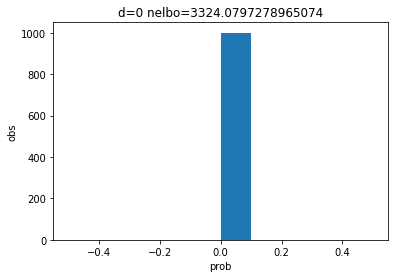

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12805
nelbo,3324.07973
entropy,-1786.7793
reconstruction_loss,-5110.85902
_runtime,185
_timestamp,1630693473
_step,12804


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
entropy,▁▅█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆
reconstruction_loss,▁▆▇▇▇▇██████████████████████████▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 47230.73452057745; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 5094.577577114333; pi: tensor([0.1809, 0.7140, 0.1051], dtype=torch.float64)
NELBO: 2594.1119054639757; pi: tensor([0.0690, 0.8908, 0.0402], dtype=torch.float64)
NELBO: 2305.170785174273; pi: tensor([0.0322, 0.9490, 0.0188], dtype=torch.float64)
NELBO: 2252.5138352031963; pi: tensor([0.0173, 0.9725, 0.0102], dtype=torch.float64)
NELBO: 2236.0170174831474; pi: tensor([0.0100, 0.9841, 0.0059], dtype=torch.float64)
NELBO: 2227.7941728124633; pi: tensor([0.0060, 0.9904, 0.0036], dtype=torch.float64)
NELBO: 2223.134353854007; pi: tensor([0.0037, 0.9941, 0.0022], dtype=torch.float64)
NELBO: 2220.3841458151974; pi: tensor([0.0023, 0.9963, 0.0014], dtype=torch.float64)
NELBO: 1969.016216152102; pi: tensor([0.0023, 0.9945, 0.0032], dtype=torch.float64)
NELBO: 1821.7341141955453; pi: tensor([0.0033, 0.9679, 0.0288], dtype=torch.float64)
NELBO: 1775.479735663294; pi: tensor([0.0018, 0.9631, 0.0351], dtype=t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


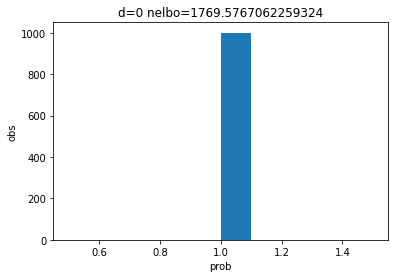

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13005
nelbo,1769.57671
entropy,-2197.23267
reconstruction_loss,-3966.80937
_runtime,185
_timestamp,1630693664
_step,13004


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▅▆██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▅▆▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 41550.69620854089; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 2549.1919066513774; pi: tensor([0.4946, 0.3085, 0.1969], dtype=torch.float64)
NELBO: 1506.3304813442269; pi: tensor([0.4924, 0.3092, 0.1985], dtype=torch.float64)
NELBO: 1083.7752329288373; pi: tensor([0.4907, 0.3096, 0.1997], dtype=torch.float64)
NELBO: 785.0563259168046; pi: tensor([0.4891, 0.3101, 0.2009], dtype=torch.float64)
NELBO: 623.721074335685; pi: tensor([0.4875, 0.3105, 0.2020], dtype=torch.float64)
NELBO: 551.3814642042753; pi: tensor([0.4860, 0.3109, 0.2031], dtype=torch.float64)
NELBO: 512.7937497823052; pi: tensor([0.4844, 0.3113, 0.2043], dtype=torch.float64)
NELBO: 493.0947695410405; pi: tensor([0.4829, 0.3117, 0.2054], dtype=torch.float64)
NELBO: 481.73734070008095; pi: tensor([0.4814, 0.3121, 0.2065], dtype=torch.float64)
NELBO: 477.8185593789842; pi: tensor([0.4799, 0.3125, 0.2076], dtype=torch.float64)
NELBO: 476.2816891298846; pi: tensor([0.4785, 0.3128, 0.2087], dtype=torc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


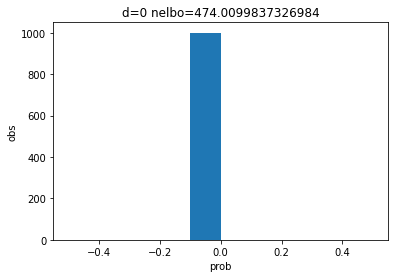

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,16726
nelbo,474.00998
entropy,-1098.6123
reconstruction_loss,-1572.62229
_runtime,236
_timestamp,1630693904
_step,16725


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▇██████████████████████████████████████
reconstruction_loss,▁▆▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43629.48362331999; pi: tensor([0.4787, 0.2840, 0.2372], dtype=torch.float64)
NELBO: 3537.66482341396; pi: tensor([0.7058, 0.1726, 0.1216], dtype=torch.float64)
NELBO: 1754.2957961794546; pi: tensor([0.6916, 0.1833, 0.1251], dtype=torch.float64)
NELBO: 1285.2753356245594; pi: tensor([0.6869, 0.1857, 0.1274], dtype=torch.float64)
NELBO: 945.1001671630383; pi: tensor([0.6835, 0.1874, 0.1291], dtype=torch.float64)
NELBO: 750.6911001671249; pi: tensor([0.6804, 0.1890, 0.1307], dtype=torch.float64)
NELBO: 657.5253643587419; pi: tensor([0.6772, 0.1905, 0.1322], dtype=torch.float64)
NELBO: 622.7557629901978; pi: tensor([0.6742, 0.1921, 0.1338], dtype=torch.float64)
NELBO: 608.9072846284432; pi: tensor([0.6711, 0.1936, 0.1353], dtype=torch.float64)
NELBO: 603.3043144739777; pi: tensor([0.6680, 0.1951, 0.1369], dtype=torch.float64)
NELBO: 600.3562344362147; pi: tensor([0.6650, 0.1966, 0.1384], dtype=torch.float64)
NELBO: 598.3683363343237; pi: tensor([0.6619, 0.1981, 0.1400], dtype=torch.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


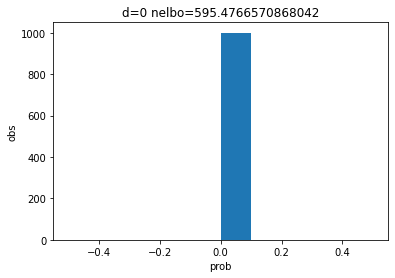

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13694
nelbo,595.47666
entropy,-1123.56494
reconstruction_loss,-1719.0416
_runtime,206
_timestamp,1630694115
_step,13693


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▆██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▄▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 43880.02860855742; pi: tensor([0.2371, 0.4784, 0.2844], dtype=torch.float64)
NELBO: 2926.6118933958037; pi: tensor([0.1595, 0.5952, 0.2453], dtype=torch.float64)
NELBO: 1717.4989315060143; pi: tensor([0.1622, 0.5889, 0.2489], dtype=torch.float64)
NELBO: 1264.4873073341114; pi: tensor([0.1640, 0.5857, 0.2503], dtype=torch.float64)
NELBO: 943.0715801197603; pi: tensor([0.1654, 0.5831, 0.2514], dtype=torch.float64)
NELBO: 758.4663625643716; pi: tensor([0.1668, 0.5807, 0.2525], dtype=torch.float64)
NELBO: 664.5126069697305; pi: tensor([0.1682, 0.5783, 0.2535], dtype=torch.float64)
NELBO: 624.808266158665; pi: tensor([0.1696, 0.5759, 0.2546], dtype=torch.float64)
NELBO: 609.7681241028574; pi: tensor([0.1709, 0.5735, 0.2556], dtype=torch.float64)
NELBO: 603.7410413153566; pi: tensor([0.1723, 0.5711, 0.2566], dtype=torch.float64)
NELBO: 600.6275827123709; pi: tensor([0.1737, 0.5688, 0.2576], dtype=torch.float64)
NELBO: 598.5392505284758; pi: tensor([0.1750, 0.5665, 0.2586], dtype=torch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


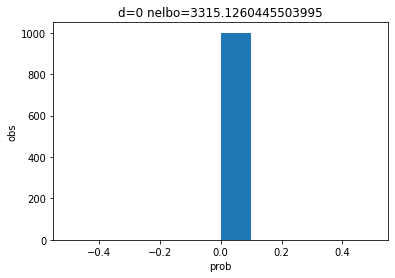

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,24375
nelbo,3315.12604
entropy,-1098.61218
reconstruction_loss,-4413.73823
_runtime,379
_timestamp,1630694500
_step,24374


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▃▃▃▃▃▃▃▃▃▃▃▃
entropy,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃
reconstruction_loss,▁▆▇▇▇█████████████████████▅▆▆▆▆▆▆▆▆▆▆▆▆▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 42224.052216134995; pi: tensor([0.2840, 0.4787, 0.2372], dtype=torch.float64)
NELBO: 5189.533847727408; pi: tensor([0.3785, 0.5053, 0.1162], dtype=torch.float64)
NELBO: 3473.100871535131; pi: tensor([0.4991, 0.4160, 0.0849], dtype=torch.float64)
NELBO: 2339.718762851715; pi: tensor([0.4808, 0.4114, 0.1077], dtype=torch.float64)
NELBO: 5435.761028809022; pi: tensor([0.4492, 0.4074, 0.1433], dtype=torch.float64)
NELBO: 3605.107095735424; pi: tensor([0.4229, 0.3995, 0.1777], dtype=torch.float64)
NELBO: 3314.2131027462447; pi: tensor([0.4001, 0.3888, 0.2110], dtype=torch.float64)
NELBO: 3200.8700995634354; pi: tensor([0.3815, 0.3769, 0.2416], dtype=torch.float64)
NELBO: 3134.2936845078148; pi: tensor([0.3681, 0.3664, 0.2656], dtype=torch.float64)
NELBO: 3078.596154789818; pi: tensor([0.3600, 0.3593, 0.2807], dtype=torch.float64)
NELBO: 3021.7484465712723; pi: tensor([0.3561, 0.3556, 0.2884], dtype=torch.float64)
NELBO: 2967.966191453065; pi: tensor([0.3544, 0.3539, 0.2917], dtype=to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


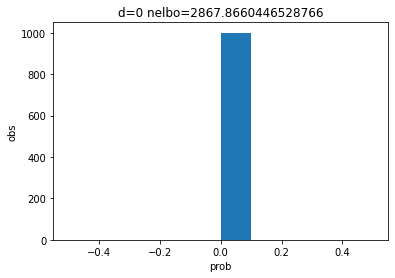

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,20528
nelbo,2867.86604
entropy,-1766.81238
reconstruction_loss,-4634.67842
_runtime,292
_timestamp,1630694798
_step,20527


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▃▂▂▂▁▁▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅▇█▇▇▇▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
reconstruction_loss,▁▆▇▇▇██▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 42218.957790678214; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 4249.458631478923; pi: tensor([0.6901, 0.2249, 0.0850], dtype=torch.float64)
NELBO: 1836.6597409467267; pi: tensor([0.7456, 0.2228, 0.0316], dtype=torch.float64)
NELBO: 983.9157806955595; pi: tensor([0.7583, 0.2271, 0.0146], dtype=torch.float64)
NELBO: 731.3669564607967; pi: tensor([0.7632, 0.2289, 0.0078], dtype=torch.float64)
NELBO: 614.0056182400422; pi: tensor([0.7657, 0.2298, 0.0045], dtype=torch.float64)
NELBO: 546.3934334233013; pi: tensor([0.7670, 0.2303, 0.0027], dtype=torch.float64)
NELBO: 516.4589667875275; pi: tensor([0.7678, 0.2306, 0.0017], dtype=torch.float64)
NELBO: 503.9784830282224; pi: tensor([0.7682, 0.2307, 0.0010], dtype=torch.float64)
NELBO: 497.3668274327515; pi: tensor([7.6851e-01, 2.3083e-01, 6.5757e-04], dtype=torch.float64)
NELBO: 493.5628908469703; pi: tensor([7.6869e-01, 2.3089e-01, 4.1453e-04], dtype=torch.float64)
NELBO: 491.2957303810849; pi: tensor([7.6881e-01, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


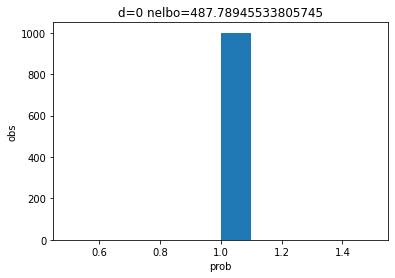

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,16466
nelbo,487.78946
entropy,-2197.56763
reconstruction_loss,-2685.35708
_runtime,234
_timestamp,1630695037
_step,16465


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂▅█▇▃▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▄▆▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 36683.48507693859; pi: tensor([0.4787, 0.2846, 0.2368], dtype=torch.float64)
NELBO: 2721.4853704355455; pi: tensor([0.4283, 0.3670, 0.2047], dtype=torch.float64)
NELBO: 1829.8309553273143; pi: tensor([0.4246, 0.3668, 0.2086], dtype=torch.float64)
NELBO: 1402.814041129449; pi: tensor([0.4227, 0.3666, 0.2107], dtype=torch.float64)
NELBO: 1049.5340394568611; pi: tensor([0.4216, 0.3663, 0.2120], dtype=torch.float64)
NELBO: 797.9068722807374; pi: tensor([0.4208, 0.3661, 0.2131], dtype=torch.float64)
NELBO: 672.707735349662; pi: tensor([0.4199, 0.3659, 0.2141], dtype=torch.float64)
NELBO: 620.028832296583; pi: tensor([0.4191, 0.3657, 0.2152], dtype=torch.float64)
NELBO: 608.7700800384823; pi: tensor([0.4183, 0.3655, 0.2162], dtype=torch.float64)
NELBO: 604.0934062358128; pi: tensor([0.4175, 0.3653, 0.2172], dtype=torch.float64)
NELBO: 601.0016927479705; pi: tensor([0.4167, 0.3651, 0.2182], dtype=torch.float64)
NELBO: 599.1321664939082; pi: tensor([0.4159, 0.3649, 0.2192], dtype=torch.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


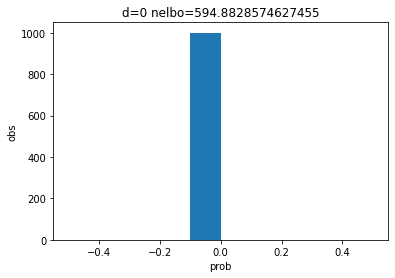

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,15196
nelbo,594.88286
entropy,-1656.51465
reconstruction_loss,-2251.39751
_runtime,218
_timestamp,1630695260
_step,15195


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁███████████████████████████████████████
reconstruction_loss,▁▆▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 39830.608797039815; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 4839.201237071323; pi: tensor([0.6217, 0.3009, 0.0774], dtype=torch.float64)
NELBO: 3115.549657694921; pi: tensor([0.5034, 0.4471, 0.0495], dtype=torch.float64)
NELBO: 2221.3825064284256; pi: tensor([0.5095, 0.3883, 0.1023], dtype=torch.float64)
NELBO: 1801.080702975144; pi: tensor([0.4823, 0.3232, 0.1945], dtype=torch.float64)
NELBO: 1491.696463741991; pi: tensor([0.4522, 0.2872, 0.2606], dtype=torch.float64)
NELBO: 1214.313640173135; pi: tensor([0.4350, 0.2699, 0.2951], dtype=torch.float64)
NELBO: 1006.6716790700493; pi: tensor([0.4257, 0.2646, 0.3097], dtype=torch.float64)
NELBO: 848.8048545524473; pi: tensor([0.4200, 0.2652, 0.3148], dtype=torch.float64)
NELBO: 731.7578559902684; pi: tensor([0.4164, 0.2673, 0.3164], dtype=torch.float64)
NELBO: 665.6469483652331; pi: tensor([0.4137, 0.2694, 0.3169], dtype=torch.float64)
NELBO: 633.4429221444668; pi: tensor([0.4116, 0.2713, 0.3171], dtype=torc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


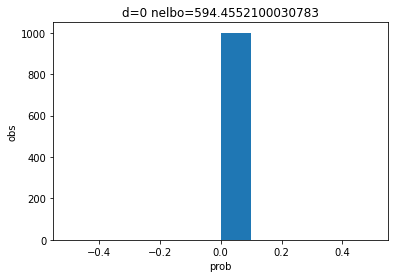

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,20076
nelbo,594.45521
entropy,-1122.45337
reconstruction_loss,-1716.90858
_runtime,295
_timestamp,1630695559
_step,20075


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▇██▇▆▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▄▆▆▇▇▇▇▇▇▇█████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 46012.63451733653; pi: tensor([0.4784, 0.2844, 0.2371], dtype=torch.float64)
NELBO: 3947.6808605756196; pi: tensor([0.6524, 0.2060, 0.1415], dtype=torch.float64)
NELBO: 1948.8919789744946; pi: tensor([0.6288, 0.2290, 0.1422], dtype=torch.float64)
NELBO: 1425.3828375582407; pi: tensor([0.6226, 0.2323, 0.1451], dtype=torch.float64)
NELBO: 1076.6234969293782; pi: tensor([0.6194, 0.2338, 0.1468], dtype=torch.float64)
NELBO: 847.8001580212058; pi: tensor([0.6166, 0.2351, 0.1483], dtype=torch.float64)
NELBO: 707.9199601779965; pi: tensor([0.6139, 0.2363, 0.1498], dtype=torch.float64)


In [ ]:
for trial in range(nt):
  
  Y = np.array(Y)
  S = np.array(S)
  kms = [KMeans(nc).fit(Y) for i in range(N_INIT)]
  inertias = [k.inertia_ for k in kms]
  km = kms[np.argmin(np.array(inertias))] ## selected "best" kmeans based on inertia score
  init_labels = km.labels_
  
  mu_init = np.array([Y[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
  sigma_init = np.array([Y[init_labels == i,:].std(0) for i in np.unique(init_labels)])
  psi_init = np.array([S[init_labels == i].mean() for i in np.unique(init_labels)])
  omega_init = np.array([S[init_labels == i].std() for i in np.unique(init_labels)])
  pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
  tau_init = np.ones((nc,nc))
  tau_init = tau_init / tau_init.sum()

  Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": F.log_softmax(torch.tensor([0.95, 1-0.95])),
    'is_pi': F.log_softmax(torch.tensor(pi_init)),
    'is_tau': F.log_softmax(torch.tensor(tau_init))
  }
  Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

  #Theta['is_delta'].requires_grad = False
  #Theta['is_pi'].requires_grad = False
  #Theta['is_tau'].requires_grad = False

  r_net = BasicForwardNet(P, nc, 5)
  v_net = BasicForwardNet(P, nc ** 2, 25)
  d_net = BasicForwardNet(P, 2, 2)

  Y = torch.tensor(Y)
  S = torch.tensor(S)
  YS = torch.hstack((Y,S.reshape(-1,1))).float()

  params = list(Theta.values()) + list(r_net.parameters()) + list(v_net.parameters()) + list(d_net.parameters())
  opt = optim.AdamW(params, lr=lr)

  wandb.init(project='jett-vi_lr1e-3_hd20_hl5',
           config={
    "N_EPOCHS": N_ITER,
    "LR": lr,
    "TOL": tol,
    'MODEL_TYPE': 'vi',
    'DATA_TYPE': 'toy_data'
  })

  loss = []
  for i in range(N_ITER):
  
    opt.zero_grad()
    r, log_r = r_net(YS)
    v, log_v = v_net(YS)
    d, log_d = d_net(YS)
  
    ## row sums to 1 (from neural net)
    log_q0 = log_d[:,0].reshape(-1,1) + log_r ## like r in em version
    log_q1 = log_d[:,1].reshape(-1,1) + log_v ## like v in em version
    
    log_rzd0, log_vgd1 = compute_joint_probs(Theta, Y, S)

    entro = (d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
    recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()

    #entro = (log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()
    #recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()
    nelbo = entro - recon

    #nelbo = (log_q0.exp() * (log_q0 - log_rzd0)).sum() + (log_q1.exp() * (log_q1 - log_vgd1)).sum()

    nelbo.backward()
    opt.step()
  
    wandb.log({
      'ITER': i + 1, 
      'nelbo': nelbo.detach(),
      'entropy': entro.detach(),
      'reconstruction_loss': recon.detach(),
      #'log_mu': Theta['log_mu'],
      #'log_sigma': Theta['log_sigma'], #np.zeros_like(sigma_init),
      #'log_psi': Theta['log_psi'],
      #'log_omega': Theta['log_omega'],
      #"is_delta": Theta['is_delta'],
      #'is_pi': Theta['is_pi'],
      #'is_tau': Theta['is_tau'],
      'r': r,
      'v': v,
      'd': d,
      })
  
    if i % (1000 - 1) == 0:
      #print("NELBO: {}; lambda: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      #print("NELBO: {}; entro: {}; recon: {}; pi: {}".format(nelbo.detach(), entro.detach(), recon.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      print("NELBO: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  
    if i > 0 and abs(loss[-1] - nelbo.detach()) < tol:
      break
           
    loss.append(nelbo.detach())

  print("trial: {} NELBO: {} D: {} PI: {}".format(trial, nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  print(Theta)

  plt.figure()
  plt.hist(np.array(d.T[0].detach().numpy()))
  plt.title('d=0 nelbo={}'.format(nelbo.detach()))
  plt.xlabel('prob')
  plt.ylabel('obs')
  plt.show()